# Ausgangssituation: 
Uns vorliegt ein Datensatz mit Transaktionsdaten und ein Auszug aus CRM mit den Kundendaten. 
Die Situation spielt am 30.11.2014 ab und es wird eine Vorhersage für die Zahlungseingänge im Dezember 2014 gewünscht.
Fangen wir zunächst mit dem Einlesen der Daten und Vorbereitung, bzw. Untersuchung des Datensatzes an.

In [13]:
#importiere die üblchen Libraries
import pandas as pd
import numpy as np
#Lese die Daten ein: Customers and Orders files
orders = pd.read_csv('Orders.csv')
customers = pd.read_csv('Customers.csv')


In [15]:
orders.head()

,OrderID,InvoiceDate,CustomerID,OrderVolume,ShipMode,Segment,Category,PaymentTerm,Discount,ExistingPurchaseOrder,FirstCustomerOrder,CashInDate
0,O-100,2011-01-03,1024,276.1,Same Day,Corporate,Office Supplies,30,5%,Yes,Yes,2011-02-18
1,O-101,2011-01-03,1024,35.88,Same Day,Corporate,Office Supplies,30,5%,Yes,No,2011-02-18
2,O-102,2011-01-05,1006,66.12,Second Class,Consumer,Office Supplies,30,3%,Yes,Yes,2011-02-06
3,O-104,2011-01-06,1023,408.3,Standard Class,Consumer,Office Supplies,30,5%,No,Yes,2011-02-17
4,O-105,2011-01-06,1009,314.22,Standard Class,Consumer,Technology,45,3%,Yes,Yes,2011-02-10


In [16]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37642 entries, 0 to 37641
Data columns (total 12 columns):
OrderID                  37642 non-null object
InvoiceDate              37642 non-null object
CustomerID               37642 non-null int64
OrderVolume              37633 non-null object
ShipMode                 37642 non-null object
Segment                  37642 non-null object
Category                 37642 non-null object
PaymentTerm              37642 non-null int64
Discount                 37626 non-null object
ExistingPurchaseOrder    37642 non-null object
FirstCustomerOrder       37642 non-null object
CashInDate               37642 non-null object
dtypes: int64(2), object(10)
memory usage: 3.4+ MB


In [17]:
customers.head()

,CustomerID,Customer,Market,CustomerComplaints
0,1000,Didier Evra,Africa,7
1,1001,Jean Tedeaux,Canada,1
2,1002,HBSA LLC,Canada,4
3,1003,Bikes and More SE,EU,0
4,1004,Patrick Johnson,US,7


In [18]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 4 columns):
CustomerID            32 non-null int64
Customer              32 non-null object
Market                32 non-null object
CustomerComplaints    32 non-null int64
dtypes: int64(2), object(2)
memory usage: 1.1+ KB


Beide Tabellen beinhalten die Spalte Customer ID. Die Einträge dort sehen konsistent aus. Zunächst verbinden wir die beiden Datasets 
über die Spalte 'CustomerID'

In [19]:
data = pd.merge(orders, customers, how = 'left', on='CustomerID' )

In [20]:
data.head()

,OrderID,InvoiceDate,CustomerID,OrderVolume,ShipMode,Segment,Category,PaymentTerm,Discount,ExistingPurchaseOrder,FirstCustomerOrder,CashInDate,Customer,Market,CustomerComplaints
0,O-100,2011-01-03,1024,276.1,Same Day,Corporate,Office Supplies,30,5%,Yes,Yes,2011-02-18,Indonesian Airways Ltd,APAC,0
1,O-101,2011-01-03,1024,35.88,Same Day,Corporate,Office Supplies,30,5%,Yes,No,2011-02-18,Indonesian Airways Ltd,APAC,0
2,O-102,2011-01-05,1006,66.12,Second Class,Consumer,Office Supplies,30,3%,Yes,Yes,2011-02-06,Joseph Omer,EMEA,5
3,O-104,2011-01-06,1023,408.3,Standard Class,Consumer,Office Supplies,30,5%,No,Yes,2011-02-17,James King,Africa,8
4,O-105,2011-01-06,1009,314.22,Standard Class,Consumer,Technology,45,3%,Yes,Yes,2011-02-10,Robert Sherbatsky,Canada,3


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37642 entries, 0 to 37641
Data columns (total 15 columns):
OrderID                  37642 non-null object
InvoiceDate              37642 non-null object
CustomerID               37642 non-null int64
OrderVolume              37633 non-null object
ShipMode                 37642 non-null object
Segment                  37642 non-null object
Category                 37642 non-null object
PaymentTerm              37642 non-null int64
Discount                 37626 non-null object
ExistingPurchaseOrder    37642 non-null object
FirstCustomerOrder       37642 non-null object
CashInDate               37642 non-null object
Customer                 37642 non-null object
Market                   37642 non-null object
CustomerComplaints       37642 non-null int64
dtypes: int64(3), object(12)
memory usage: 4.6+ MB


Merkwürdigerweise sind nur drei Spalten vom Typ int64, also numerisch. Der Rest ist vom Typ Objekt. 

In [23]:
print('Rows, Columns:', data.shape)
print('Datatype Count:', data.dtypes.value_counts())

Rows, Columns: (37642, 15)
Datatype Count: object    12
int64      3
dtype: int64


## CashInDate und InvoiceDate
Zuerst transformiere ich die Spalten mit Rechungsdatum und Zahlungseingangsdatum ins Typ Datetime

In [24]:
from datetime import datetime, date
data.InvoiceDate = pd.to_datetime(data.InvoiceDate, yearfirst=True, dayfirst=True)
data.CashInDate = pd.to_datetime(data.CashInDate, yearfirst=True, dayfirst=True )

Haben wir fehlende Daten?

In [25]:
#Missing Values
def check_missing_data(df):
    flag=df.isna().sum().any()
    if flag==True:
        total = df.isnull().sum()
        percent = (df.isnull().sum()*100)/(df.isnull().count())
        output = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
        data_type = []
        for col in df.columns:
            dtype = str(df[col].dtype)
            data_type.append(dtype)
        output['Types'] = data_type
        return(output)
    else:
        return(False)

In [26]:
check_missing_data(data)

,Total,Percent,Types
OrderID,0,0.000000,object
InvoiceDate,0,0.000000,datetime64[ns]
CustomerID,0,0.000000,int64
OrderVolume,9,0.023909,object
ShipMode,0,0.000000,object
Segment,0,0.000000,object
Category,0,0.000000,object
PaymentTerm,0,0.000000,int64
Discount,16,0.042506,object
ExistingPurchaseOrder,0,0.000000,object


Ich nehme an, dass die fehlende Daten über Preisnachlass darauf hindeuten, dass es in diesen Fällen keinen Preisnachlass gegeben hat.
Die 16 fehlende Angaben über Preisreduzierung befülle ich also mit 0.

In [27]:
data.Discount.fillna(value =0, inplace = True)

Die Größe der Bestellung dagegen ist sehr bedeutend. Da es nur 9 Datensätze gibt, be der die Angaben fehlen, entferne ich diese Zeilen.

In [28]:
data = data.dropna()

## OrderVolume
In der Spalte OrderVolume haben ein Paar Einträge '$' hinter der Zahl, weswegen die Daten nicht numerisch sind. Ich entferne diese und konvertiere die Daten ins Numerische.

In [29]:
data.OrderVolume = data.OrderVolume.str.replace('$', '')
data.OrderVolume= pd.to_numeric(data.OrderVolume)

## Discount
Jetzt schauen wir uns die Spalte Discount an. Welche Werte beinhaltet diese?

In [30]:
data.Discount.value_counts()

5%    18742
3%     9438
0%     9437
0        16
Name: Discount, dtype: int64

Ich entferne das %-Zeichen und teile die Zahlen durch 100, um die Prozentsätze zu bekommen.

In [31]:
data.Discount = data.Discount.str.replace('%', '')
data.Discount = pd.to_numeric(data.Discount)/100
data.Discount.fillna(value =0, inplace = True)

## Segment
Setzten wir die Untersuchung fort. Welche Werte hat die Spalte Segment?

In [32]:
data.Segment.value_counts()

Consumer     19442
Corporate    18191
Name: Segment, dtype: int64

Es handelt sich um kategorische Daten mit zwei möglichen Ausgängen. Ersetze diese durch 1 und 0.

In [33]:
#Convert it to 0 for Consumer and 1 for Corporate
data.Segment.replace(('Corporate', 'Consumer'), (1, 0), inplace=True)

## ExistingPurchaseOrder
Gibt es einen Kundenauftrag? Ersetze wieder 'ja' durch 1 und 'nein' durch 0.

In [35]:
#ersetzte 'Yes' und 'No' durch 1 und 0
data.ExistingPurchaseOrder.replace(('Yes', 'No'), (1, 0), inplace=True)

## FirstCustomerOrder
Und wieder ersetzte 'ja' durch 1 und 'nein' durch 0.

In [36]:
#Gleiches Spiel: ersetzte 'Yes' und 'No' durch 1 und 0
data.FirstCustomerOrder.replace(('Yes', 'No'), (1, 0), inplace=True)

## DaysBetween
Definiere nun unsere Target-Spalte. Die Anzahl der Tage zwischen dem Rechnungsdatum und der Eingang der Zahlung

In [38]:
#Definiere die neue Spalte mit Anzahl der Tage zwischen Invoice und Cash In:
data['DaysBetween'] = (data.CashInDate- data.InvoiceDate).apply(lambda x: x.days)


## ShipMode, Category, Market
Diese Spalten beinhalten kategorische Daten mit mehreren Möglichkeiten. Diese bearbeite ich später mit Hilfe von hot-one-coding.

## OrderID
Diese Spalte trägt nicht zum Model bei und wrd von mir später entfernt

## Customer
Beinhaltet dieselbe Information, wie CustomerID im Sinne von diesem Use Case. Diese entferne ich auch.

In [43]:
data.DaysBetween.value_counts().sort_values().head()

 77     1
-173    1
-165    1
 78     2
 76     3
Name: DaysBetween, dtype: int64

Komischerweise haben wir zwei  Fälle, bei den das Geld eingegangen ist, noch bevor die Rechnung erstellt wurde. Diese sind offensichtlich fehlerhaft. Ich entferne diese und schaue mir die Verteilung der Wartezeiten an.

(array([ 253.,   98.,  204.,  113.,  345.,  210.,  521.,  311.,  689.,
         467.,  921.,  550., 1266.,  659., 1588.,  826., 1856.,  979.,
        2061., 1127., 2232., 1108., 2356., 1118., 2207., 1026., 2024.,
         929., 1755.,  783., 1434.,  731., 1204.,  483.,  923.,  369.,
         592.,  252.,  403.,  132.,  235.,   67.,  104.,   32.,   45.,
          12.,   21.,    4.,    3.,    3.]),
 array([ 3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. , 16.5, 18. ,
        19.5, 21. , 22.5, 24. , 25.5, 27. , 28.5, 30. , 31.5, 33. , 34.5,
        36. , 37.5, 39. , 40.5, 42. , 43.5, 45. , 46.5, 48. , 49.5, 51. ,
        52.5, 54. , 55.5, 57. , 58.5, 60. , 61.5, 63. , 64.5, 66. , 67.5,
        69. , 70.5, 72. , 73.5, 75. , 76.5, 78. ]),
 <a list of 50 Patch objects>)

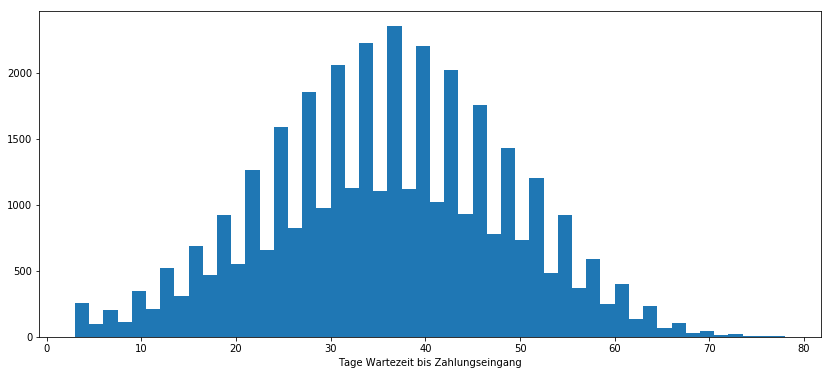

In [80]:
data = data[data.DaysBetween>=0]
#Wie sieht die Verteilung der Wartezeit aus?
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize= (14,6))
plt.xlabel('Tage Wartezeit bis Zahlungseingang')
plt.hist(data.DaysBetween, bins = 50)

Schöne Glockenkurve der Normalverteilung.

## Aufteilung in Train und Test und Modelvorbereitung

Laut Aufgabe, befinden wir uns am 30.11.2014 und wollen eine Vorhersage für Dezember machen. Sortiere die Daten nach Zahlungseingangsdatum und teile diese auf. Wir trainieren das Model auf historischen Daten bis 30.11.2014 und testen dieses auf der Daten für Dezember.

In [45]:
data = data.sort_values('CashInDate')
data_train = data[data.CashInDate<= '2014-11-30'].set_index('InvoiceDate')
data_test= data[data.CashInDate > '2014-11-30'].set_index('InvoiceDate')

Verwende die Methode get_dummies() von Pandas um mit one-hot-coding die kategorische Daten in numerische umzuwandeln.
Definiere die unabhänguge Variable X und die Target-Variable y, wie oben beschrieben.

In [46]:
data_train = pd.get_dummies(data_train , columns = ['ShipMode', 'Category', 'Market'], dtype=int)
data_test = pd.get_dummies(data_test , columns = ['ShipMode', 'Category', 'Market'], dtype=int)
X_train = data_train.drop(['OrderID','CashInDate', 'Customer', 'DaysBetween'], axis = 1)
X_test = data_test.drop(['OrderID','CashInDate', 'Customer', 'DaysBetween'], axis = 1)
y_train= data_train.DaysBetween
y_test = data_test.DaysBetween

## Prediction
Es eignet sich bei solchen Aufgaben der Random Forest Regressor sehr gut. Importiere das Modell und trainiere dieses mit 100 Entscheidungsbäumen und der maximalen Tiefe 10, um Overfitting zu vermeiden.

In [48]:
from sklearn.ensemble import RandomForestRegressor

In [52]:
model = RandomForestRegressor(n_estimators=100, max_depth=10)
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

Mache eine Vorhersage mit dem Modell.

In [53]:
prediction = model.predict(X_test)

## Bewertung des Modells

Als Metrik für die Genauigkeit haben wir den RSME, also Wurzel aus dem mittleren quadratischen Fehler i.H.v. ca 4 gegeben. Dann ist das Modell gut genug. Prüfe, ob die Ergebnisse dieser Metrik genügen.

In [54]:
print(np.sqrt(((prediction - y_test) ** 2).mean()))

4.208212737754282


Das Ergebnis liegt nahe 4. Prüfe nun Score des Modells.

In [55]:
model.score(X_test,y_test)

0.8696127955548631

87% ist tatsächlich ziemlich gut.Visualisiere zunächst die Ergebnisse: reale Werte vs die Vorhersage

Text(0.5, 1.0, 'Echt vs Vorhersage')

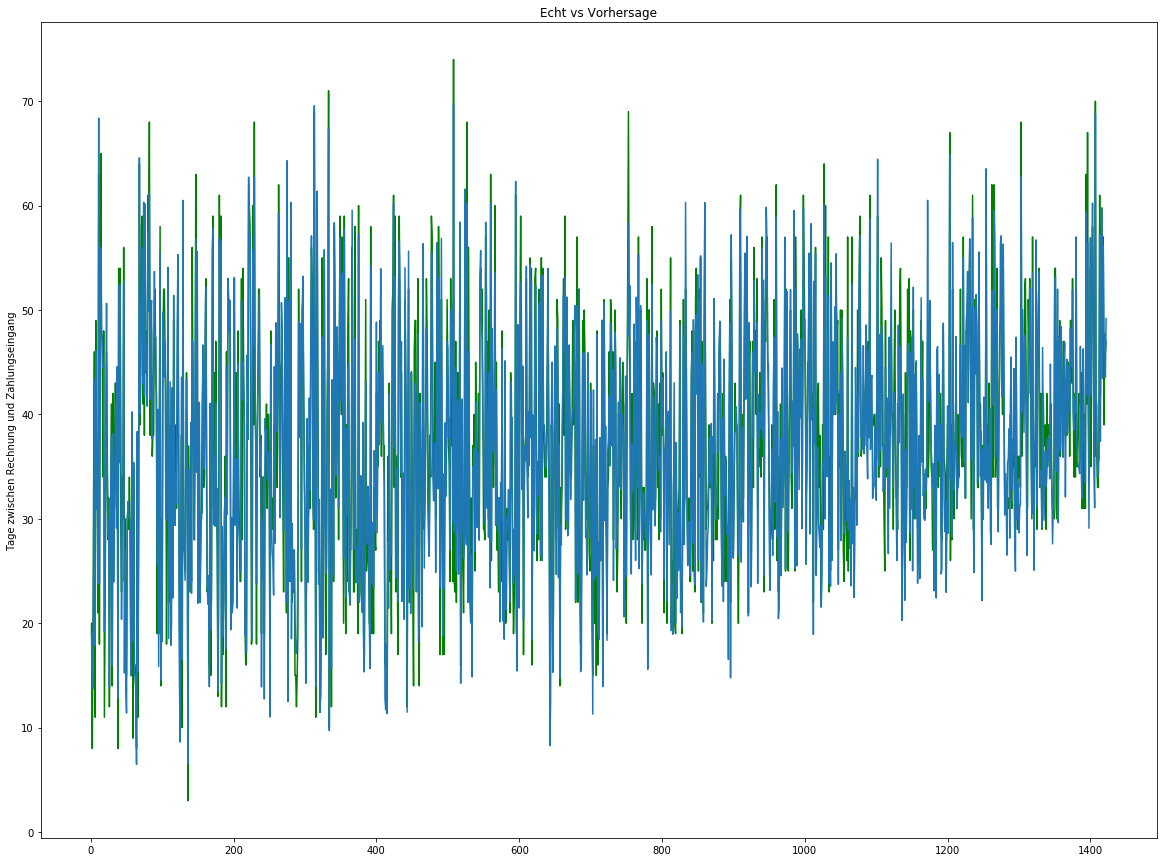

In [85]:
#Visualisiere die Ergebnisse
plt.figure(figsize=(20, 15))
plt.plot(range(1,1423), y_test, color = 'green')
plt.plot(range(1,1423), prediction)
plt.ylabel('Tage zwischen Rechnung und Zahlungseingang')
plt.title('Echt vs Vorhersage')


## Expected Cash In per Day
Jetzt wollen wir den zweiten Teil der Aufgabe erledigen: aggregiere die Summe der vorhergesagten Zahlungseingänge per Tag im Dezember.
Dazu fügen wir die Spalte mit den echten Daten, sowie die vorhergesagte Werte dem X_test hinzu und gruppieren diesen.

In [57]:
X_test['PredictedDays'] = pd.Series(prediction)
X_test= X_test.assign(PredictedDays = prediction)
X_test['RealDays'] = y_test
X_test.PredictedDays = X_test.PredictedDays.apply(lambda x: round(x))

Füge die Indizes als Spalte wieder zurück, um den Tag der Zahlungseingänge zu berechnen. Addiere dazu die vorhergesagte, sowie die realen Tage zum Rechnungsdatum.

In [60]:
final_data = X_test.reset_index()

In [62]:
from datetime import timedelta
final_data['PredictedCashInDate'] = final_data.InvoiceDate + final_data.PredictedDays.apply(lambda x: timedelta(days = x))
final_data['CashInDate'] = final_data.InvoiceDate + final_data.RealDays.apply(lambda x: timedelta(days = x))

In [64]:
#Da wir wissen, dass die Zahlung erst in Dezember eingehen wird, setzten wir das Datum auf 1.Dezember, falls das vorhergesagte Datum in November liegt.

mask = final_data.PredictedCashInDate < '2014-12-01'
column_name = 'PredictedCashInDate'
final_data.loc[mask, column_name] = '2014-12-01'

In [67]:
final_data['PredictedCashInDate'] = pd.to_datetime(final_data['PredictedCashInDate'])

Erstelle ein DataFrame in gewünschter Form, wie Aufgabe 2 verlangt.

In [70]:
prediction_date_cash = final_data.groupby('PredictedCashInDate')['OrderVolume'].sum()

Und ein Mal für die tatsächlichen Daten.

In [73]:
real_date_cash = final_data.groupby('CashInDate')['OrderVolume'].sum()

In [71]:
prediction_date_cash.head()

PredictedCashInDate
2014-12-01    23737.38
2014-12-02     8453.92
2014-12-03     5190.33
2014-12-04     9931.30
2014-12-05     6939.83
Name: OrderVolume, dtype: float64

Visualisiere den Cash In für Dezember. Vorhersage vs Realität.

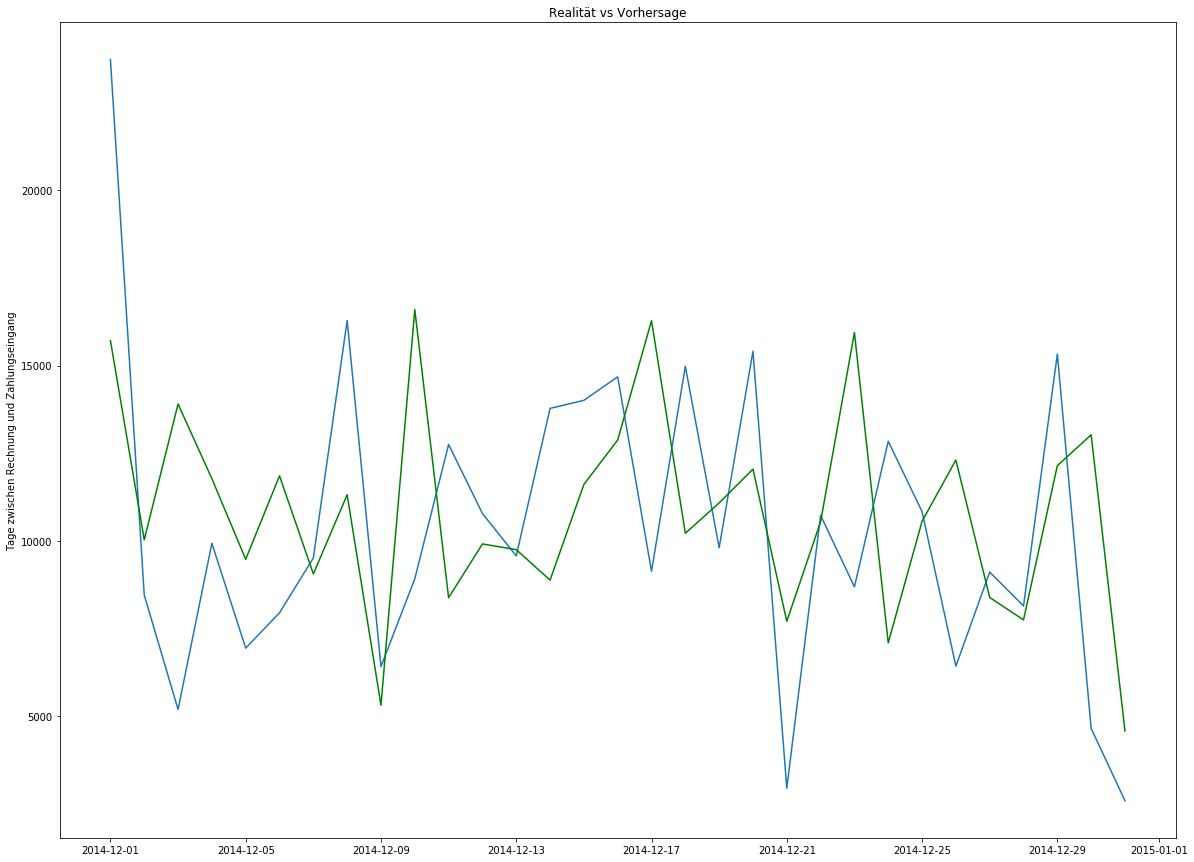

In [88]:
plt.figure(figsize=(20, 15))
plt.ylabel('Tage zwischen Rechnung und Zahlungseingang')
plt.title('Realität vs Vorhersage')
plt.plot(prediction_date_cash.loc[:'2014-12-31'])
plt.plot(real_date_cash , color = 'green')

Wir haben die Vorhersage wirklich gut getroffen. Der Trend ist definitiv zu erkennen.
Speichere nun die Ergebnisse in einer Excel-Tabelle.

In [79]:
prediction_date_cash.loc[:'2014-12-31'].to_excel('Expected Cash In December.xls')